In [4]:
import sys
from dotenv import load_dotenv
import os

load_dotenv()

sys.path.append(os.getenv("ROOT"))

In [5]:
import polars as pl
import numpy as np
from datetime import date
from silverfund.datasets.crsp_daily import CRSPDaily
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Load dataset
df = CRSPDaily(start_date=date(2020, 1, 1), end_date=date(2024, 12, 31)).load_all().select(["permno", "ticker", "date", "shrout", "prc", "ret"])

df

Loading CRSP Daily years:   0%|          | 0/5 [00:00<?, ?it/s]

Loading CRSP Daily years: 100%|██████████| 5/5 [00:00<00:00, 19.98it/s]


permno,ticker,date,shrout,prc,ret
i64,str,date,f64,f64,f64
10026,"""JJSF""",2020-01-02,18900.0,181.67999,-0.014056
10026,"""JJSF""",2020-01-03,18900.0,184.91,0.017779
10026,"""JJSF""",2020-01-06,18900.0,185.07001,0.000865
10026,"""JJSF""",2020-01-07,18900.0,183.03,-0.011023
10026,"""JJSF""",2020-01-08,18900.0,182.03999,-0.005409
…,…,…,…,…,…
93436,"""TSLA""",2024-11-22,3.207e6,352.56,0.03804
93436,"""TSLA""",2024-11-25,3.207e6,338.59,-0.039625
93436,"""TSLA""",2024-11-26,3.207e6,338.23001,-0.001063


In [7]:
# Form momentum signal

# Log returns
df = df.with_columns(pl.col("ret").log1p().alias("logret"))

# Rolling sum from t-252 to t-22
df = df.with_columns(pl.col("logret").rolling_sum(window_size=230, min_periods=230).shift(22).over("permno").alias("mom"))

df

permno,ticker,date,shrout,prc,ret,logret,mom
i64,str,date,f64,f64,f64,f64,f64
10026,"""JJSF""",2020-01-02,18900.0,181.67999,-0.014056,-0.014156,null
10026,"""JJSF""",2020-01-03,18900.0,184.91,0.017779,0.017623,null
10026,"""JJSF""",2020-01-06,18900.0,185.07001,0.000865,0.000865,null
10026,"""JJSF""",2020-01-07,18900.0,183.03,-0.011023,-0.011084,null
10026,"""JJSF""",2020-01-08,18900.0,182.03999,-0.005409,-0.005424,null
…,…,…,…,…,…,…,…
93436,"""TSLA""",2024-11-22,3.207e6,352.56,0.03804,0.037334,-0.091874
93436,"""TSLA""",2024-11-25,3.207e6,338.59,-0.039625,-0.040431,0.101033
93436,"""TSLA""",2024-11-26,3.207e6,338.23001,-0.001063,-0.001064,0.131252


In [8]:
# Filters

# Price greater than 5
df = df.with_columns(pl.col("prc").shift(1).over("permno").alias("prclag"))
df = df.filter(pl.col("prclag") > 5)

# Non-null momentum signal
df = df.drop_nulls(subset=["mom"])

df

permno,ticker,date,shrout,prc,ret,logret,mom,prclag
i64,str,date,f64,f64,f64,f64,f64,f64
10026,"""JJSF""",2020-12-30,18956.0,154.14999,0.000584,0.000584,-0.168765,154.06
10026,"""JJSF""",2020-12-31,18956.0,155.37,0.007914,0.007883,-0.208695,154.14999
10026,"""JJSF""",2021-01-04,18956.0,152.23,-0.02021,-0.020417,-0.232181,155.37
10026,"""JJSF""",2021-01-05,18956.0,149.92,-0.015174,-0.01529,-0.253172,152.23
10026,"""JJSF""",2021-01-06,18956.0,153.47,0.023679,0.023403,-0.226121,149.92
…,…,…,…,…,…,…,…,…
93436,"""TSLA""",2024-11-22,3.207e6,352.56,0.03804,0.037334,-0.091874,339.64001
93436,"""TSLA""",2024-11-25,3.207e6,338.59,-0.039625,-0.040431,0.101033,352.56
93436,"""TSLA""",2024-11-26,3.207e6,338.23001,-0.001063,-0.001064,0.131252,338.59


In [9]:
# Create portfolio bins

labels = [str(x) for x in range(10)]

df = df.with_columns(pl.col("mom").qcut(10, labels=labels).over("date").alias("bin"))

df

permno,ticker,date,shrout,prc,ret,logret,mom,prclag,bin
i64,str,date,f64,f64,f64,f64,f64,f64,cat
10026,"""JJSF""",2020-12-30,18956.0,154.14999,0.000584,0.000584,-0.168765,154.06,"""2"""
10026,"""JJSF""",2020-12-31,18956.0,155.37,0.007914,0.007883,-0.208695,154.14999,"""2"""
10026,"""JJSF""",2021-01-04,18956.0,152.23,-0.02021,-0.020417,-0.232181,155.37,"""2"""
10026,"""JJSF""",2021-01-05,18956.0,149.92,-0.015174,-0.01529,-0.253172,152.23,"""1"""
10026,"""JJSF""",2021-01-06,18956.0,153.47,0.023679,0.023403,-0.226121,149.92,"""1"""
…,…,…,…,…,…,…,…,…,…
93436,"""TSLA""",2024-11-22,3.207e6,352.56,0.03804,0.037334,-0.091874,339.64001,"""1"""
93436,"""TSLA""",2024-11-25,3.207e6,338.59,-0.039625,-0.040431,0.101033,352.56,"""3"""
93436,"""TSLA""",2024-11-26,3.207e6,338.23001,-0.001063,-0.001064,0.131252,338.59,"""4"""


In [10]:
# Create portfolio returns dataframe

# Aggregate (equal weight portfolios)
port = df.group_by(["date", "bin"]).agg(pl.col("ret").mean())

# Pivot
port = port.pivot(on="bin", index="date", values="ret")

# Reorder columns
port = port.select(["date"] + labels)

# Sort
port = port.sort(by="date")

port

date,0,1,2,3,4,5,6,7,8,9
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2020-12-30,0.013844,0.009458,0.007448,0.008892,0.01187,0.006499,0.005436,0.008191,0.011475,0.020899
2020-12-31,0.006389,0.002074,0.002271,0.003167,-0.000011,0.002477,0.002234,-0.000301,-0.004824,-0.016601
2021-01-04,-0.006276,-0.012433,-0.008544,-0.011573,-0.010015,-0.011456,-0.013129,-0.01209,-0.012048,-0.003703
2021-01-05,0.031812,0.012208,0.012526,0.012961,0.011531,0.009542,0.016953,0.019807,0.018364,0.020452
2021-01-06,0.033659,0.04433,0.043662,0.040917,0.034062,0.031903,0.027385,0.025757,0.017832,0.020204
…,…,…,…,…,…,…,…,…,…,…
2024-11-22,0.023205,0.016296,0.018161,0.013103,0.017811,0.013032,0.014177,0.015796,0.018677,0.025977
2024-11-25,0.027911,0.023012,0.019137,0.01154,0.012576,0.011462,0.010805,0.011359,0.011915,0.00751
2024-11-26,-0.015452,-0.01171,-0.010272,-0.005548,-0.005473,-0.004414,-0.003985,-0.001203,-0.000973,-0.000014


In [11]:
# Create spread portfolio

port = port.with_columns((pl.col("9") - pl.col("0")).alias("spread"))

port

date,0,1,2,3,4,5,6,7,8,9,spread
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2020-12-30,0.013844,0.009458,0.007448,0.008892,0.01187,0.006499,0.005436,0.008191,0.011475,0.020899,0.007055
2020-12-31,0.006389,0.002074,0.002271,0.003167,-0.000011,0.002477,0.002234,-0.000301,-0.004824,-0.016601,-0.02299
2021-01-04,-0.006276,-0.012433,-0.008544,-0.011573,-0.010015,-0.011456,-0.013129,-0.01209,-0.012048,-0.003703,0.002572
2021-01-05,0.031812,0.012208,0.012526,0.012961,0.011531,0.009542,0.016953,0.019807,0.018364,0.020452,-0.011359
2021-01-06,0.033659,0.04433,0.043662,0.040917,0.034062,0.031903,0.027385,0.025757,0.017832,0.020204,-0.013455
…,…,…,…,…,…,…,…,…,…,…,…
2024-11-22,0.023205,0.016296,0.018161,0.013103,0.017811,0.013032,0.014177,0.015796,0.018677,0.025977,0.002772
2024-11-25,0.027911,0.023012,0.019137,0.01154,0.012576,0.011462,0.010805,0.011359,0.011915,0.00751,-0.020401
2024-11-26,-0.015452,-0.01171,-0.010272,-0.005548,-0.005473,-0.004414,-0.003985,-0.001203,-0.000973,-0.000014,0.015437


In [12]:
# Unpivot dataframe
port = port.unpivot(index="date", variable_name="bin", value_name="ret")

# Sort
port = port.sort(by=["date", "bin"])

port

date,bin,ret
date,str,f64
2020-12-30,"""0""",0.013844
2020-12-30,"""1""",0.009458
2020-12-30,"""2""",0.007448
2020-12-30,"""3""",0.008892
2020-12-30,"""4""",0.01187
…,…,…
2024-11-29,"""6""",0.003542
2024-11-29,"""7""",0.003175
2024-11-29,"""8""",0.001676


In [13]:
# Calculate mean, std, sharpe, and tstat of each portfolio

# Mean, std, and count
result = port.group_by("bin").agg(
    [
        pl.col("ret").mean().cast(pl.Float64).alias("mean"),
        pl.col("ret").std().cast(pl.Float64).alias("std"),
        pl.col("ret").count().cast(pl.Float64).alias("count"),
    ]
)

# Sharpe
result = result.with_columns(((pl.col("mean") * 252) / (pl.col("std") * np.sqrt(252))).cast(pl.Float64).alias("annualized_sharpe"))

# Tstat
result = result.with_columns((pl.col("mean") / (pl.col("std") / pl.col("count").sqrt())).cast(pl.Float64).alias("tstat"))

# Sort
result = result.sort(by="bin")

# Transpose
result = result.transpose(include_header=True, column_names="bin", header_name="statistic")

print("Daily results")
result

Daily results


statistic,0,1,2,3,4,5,6,7,8,9,spread
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""mean""",-0.000256,0.000176,0.000338,0.000451,0.00063,0.000632,0.000399,0.000537,0.000601,0.00058,0.000837
"""std""",0.021462,0.015621,0.013367,0.012073,0.011127,0.010592,0.010288,0.011161,0.012795,0.017146,0.016273
"""count""",986.0,986.0,986.0,986.0,986.0,986.0,986.0,986.0,986.0,986.0,986.0
"""annualized_sharpe""",-0.18946,0.178517,0.400974,0.592563,0.899194,0.947762,0.615489,0.76367,0.745381,0.537361,0.816029
"""tstat""",-0.374762,0.353117,0.793149,1.172121,1.778655,1.874725,1.21747,1.51058,1.474405,1.062928,1.61415


In [14]:
# Create backtest plot

# Log returns
port = port.with_columns(pl.col("ret").log1p().over("bin").alias("logret"))

# Cummulative sum log returns
port = port.with_columns(pl.col("logret").cum_sum().over("bin").alias("cumret") * 100)

port

date,bin,ret,logret,cumret
date,str,f64,f64,f64
2020-12-30,"""0""",0.013844,0.013749,1.374892
2020-12-30,"""1""",0.009458,0.009414,0.941372
2020-12-30,"""2""",0.007448,0.00742,0.741997
2020-12-30,"""3""",0.008892,0.008853,0.885299
2020-12-30,"""4""",0.01187,0.0118,1.180003
…,…,…,…,…
2024-11-29,"""6""",0.003542,0.003536,34.113374
2024-11-29,"""7""",0.003175,0.00317,46.795626
2024-11-29,"""8""",0.001676,0.001674,51.156589


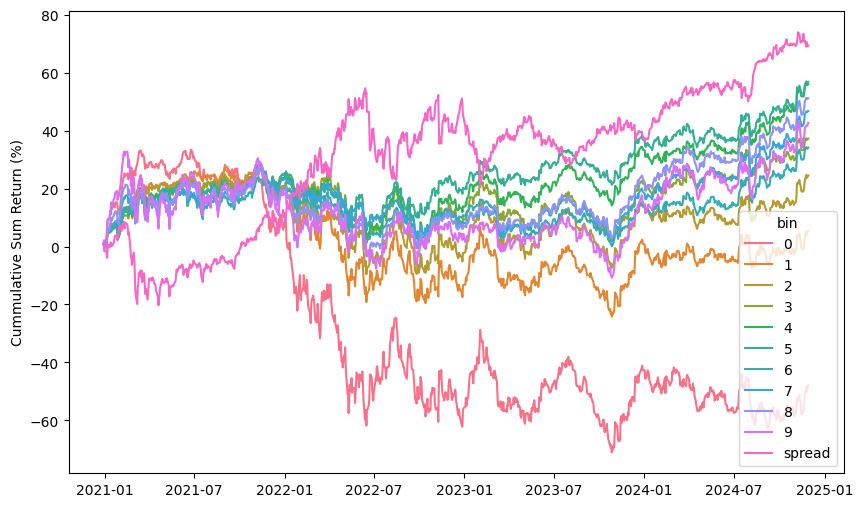

In [15]:
plt.figure(figsize=(10, 6))
sns.lineplot(port, x="date", y="cumret", hue="bin")
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

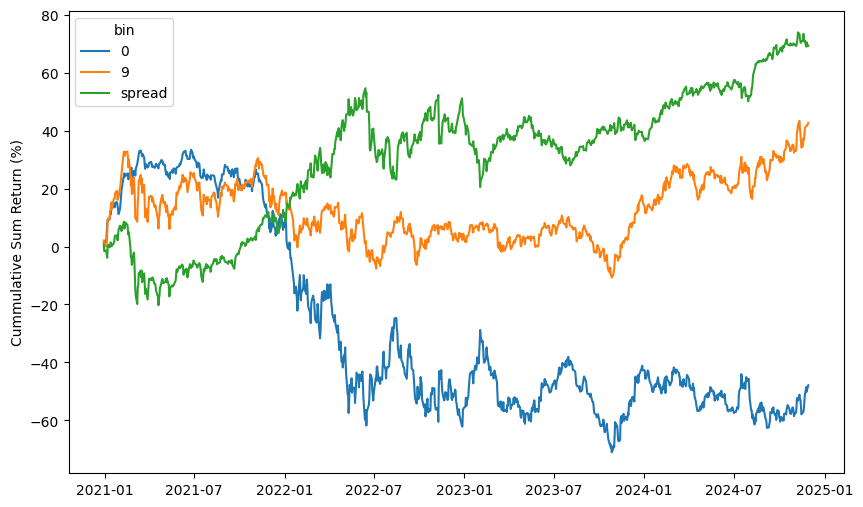

In [16]:
plt.figure(figsize=(10, 6))
sns.lineplot(port.filter(pl.col("bin").is_in(["0", "9", "spread"])), x="date", y="cumret", hue="bin")
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

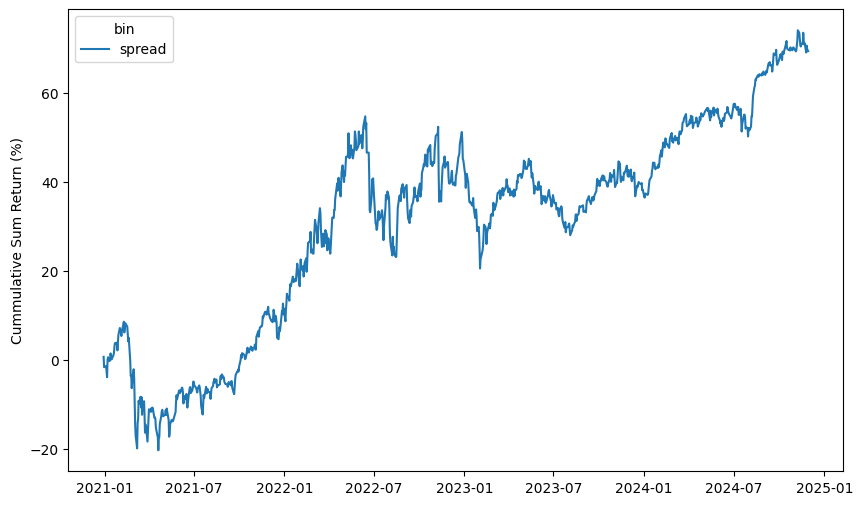

In [17]:
plt.figure(figsize=(10, 6))
sns.lineplot(port.filter(pl.col("bin") == "spread"), x="date", y="cumret", hue="bin")
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

In [18]:
min_date = port["date"].min().strftime("%Y-%m-%d")
max_date = port["date"].max().strftime("%Y-%m-%d")

print(f"From {min_date} to {max_date}")

From 2020-12-30 to 2024-11-29
